# DonorsChoose: Donor-Project Matching with Recommender Systems
Data and project idea come from a [Kaggle competition](https://www.kaggle.com/donorschoose/io).
Much of the recommender work is based on a [tutorial](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/code) by [Gabriel Moreira](https://www.kaggle.com/gspmoreira).

# Donors Choose
Founded in 2000 by a Bronx history teacher, DonorsChoose.org has raised $685 million for America's classrooms. Teachers at three-quarters of all the public schools in the U.S. have come to DonorsChoose.org to request what their students need, making DonorsChoose.org the leading platform for supporting public education.

To date, 3 million people and partners have funded 1.1 million DonorsChoose.org projects. But teachers still spend more than a billion dollars of their own money on classroom materials. To get students what they need to learn, the team at DonorsChoose.org needs to be able to connect donors with the projects that most inspire them.

In the second Kaggle Data Science for Good challenge, DonorsChoose.org, in partnership with Google.org, is inviting the community to help them pair up donors to the classroom requests that will most motivate them to make an additional gift. To support this challenge, DonorsChoose.org has supplied anonymized data on donor giving from the past five years. The winning methods will be implemented in DonorsChoose.org email marketing campaigns.

# Problem Statement
DonorsChoose.org has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled.

A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors. Part of the challenge is to assess the needs of the organization, uncover insights from the data available, and build the right solution for this problem. Submissions will be evaluated on the following criteria:

Performance - How well does the solution match donors to project requests to which they would be motivated to donate? DonorsChoose.org will not be able to live test every submission, so a strong entry will clearly articulate why it will be effective at motivating repeat donations.

Adaptable - The DonorsChoose.org team wants to put the winning submissions to work, quickly. Therefore a good entry will be easy to implement in production.

Intelligible - A good entry should be easily understood by the DonorsChoose.org team should it need to be updated in the future to accommodate a changing marketplace.

# Proposed Solution

I will address the problem by using [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) (RecSys) techniques. The objective of a RecSys is to recommend relevant items for users, based on their preference. Preference and relevance are subjective, and they are generally inferred by items users have consumed previously.

The main RecSys techniques are:  
   - [**Collaborative Filtering**](https://en.wikipedia.org/wiki/Collaborative_filtering): This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   
   - [**Content-Based Filtering**](http://recommender-systems.org/content-based-filtering/): This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.  
   - **Hybrid methods**:  Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

## Load libraries

In [120]:
#enable auto complete
%config IPCompleter.greedy=True
%matplotlib inline

In [121]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib as cm
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import scipy
from scipy.sparse.linalg import svds
import math
import random
import sklearn

from numpy import array

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import os
print(os.listdir("../input"))

from sklearn import preprocessing
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

['Schools.csv', 'Donations.csv', 'Resources.csv', 'Donors.csv', 'Teachers.csv', 'Projects.csv']


## Load data

In [122]:
projects = pd.read_csv('../input/Projects.csv')
donations = pd.read_csv('../input/Donations.csv')
donors = pd.read_csv('Donors.csv', low_memory=False)

In [123]:
schools = pd.read_csv('../input/Schools.csv', error_bad_lines=False)
teachers = pd.read_csv('../input/Teachers.csv', error_bad_lines=False)
resources = pd.read_csv('../input/Resources.csv', error_bad_lines=False, warn_bad_lines=False)

In [124]:
print(' donations: ',donations.shape,'\n',
'donors: ',donors.shape,'\n',
'schools',schools.shape,'\n',
'teachers',teachers.shape,'\n',
'projects',teachers.shape,'\n',
'resources',resources.shape)

 donations:  (4687884, 7) 
 donors:  (2122640, 5) 
 schools (72993, 9) 
 teachers (402900, 3) 
 projects (402900, 3) 
 resources (7210448, 5)


### Set up test mode where only 10000 rows of donation/donor dataframe are used. 
When testing is complete we will need to turn off test mode.

In [125]:
# Set up test mode to save some time
test_mode = True

# Merge datasets
donations = donations.merge(donors, on="Donor ID", how="left")
df = donations.merge(projects,on="Project ID", how="left")

# only load a few lines in test mode
if test_mode:
    df = df.head(10000)

donations_df = df
print('shape of df is ',df.shape)

shape of df is  (10000, 25)


In [126]:
#df -> donors + donations
print('shape of df is ',df.shape)

shape of df is  (10000, 25)


# EDA

In [127]:
donations.head()

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,No,840
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,Yes,840
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,No,840
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04,Phoenix,Arizona,No,850
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38,Salt Lake City,Utah,Yes,841


In [128]:
donors.head(10)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953
3,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462
4,0000300773fe015f870914b42528541b,Paterson,New Jersey,No,075
5,00004c31ce07c22148ee37acd0f814b9,NaN,other,No,NaN
6,00004e32a448b4832e1b993500bf0731,Stamford,Connecticut,No,069
7,00004fa20a986e60a40262ba53d7edf1,Green Bay,Wisconsin,No,543
8,00005454366b6b914f9a8290f18f4aed,Argyle,New York,No,128
9,0000584b8cdaeaa6b3de82be509db839,Valparaiso,Indiana,No,463


In [129]:
schools.head(3)

,School ID,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00003e0fdd601b8ea0a6eb44057b9c5e,Capon Bridge Middle School,rural,56.0,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District
1,00004e32a448b4832e1b993500bf0731,The Woodlands College Park High School,urban,41.0,Texas,77384,The Woodlands,Montgomery,Conroe Ind School District
2,0002021bb799f28de224f1acc1ff08c4,Samantha Smith Elementary School,suburban,2.0,Washington,98074,Sammamish,King,Lake Washington Sch Dist 414


In [130]:
teachers.head(3)

,Teacher ID,Teacher Prefix,Teacher First Project Posted Date
0,00000f7264c27ba6fea0c837ed6aa0aa,Mrs.,2013-08-21
1,00002d44003ed46b066607c5455a999a,Mrs.,2016-10-23
2,00006084c3d92d904a22e0a70f5c119a,Mr.,2016-09-08


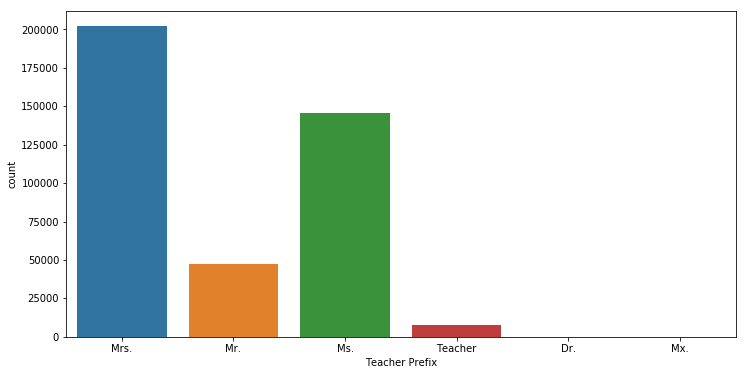

In [131]:
plt.rcParams["figure.figsize"] = [12,6]
#teachers['Teacher Prefix'].plot(kind = 'bar')
sns.countplot(x='Teacher Prefix', data=teachers);

In [132]:
projects.head(3)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Current Status,Project Fully Funded Date
0,77b7d3f2ac4e32d538914e4a8cb8a525,c2d5cb0a29a62e72cdccee939f434181,59f7d2c62f7e76a99d31db6f62b7b67c,2,Teacher-Led,Anti-Bullying Begins with Me,do you remember your favorite classroom from e...,"Applied Learning, Literacy & Language","Character Education, Literacy",Grades PreK-2,Books,$490.38,2013-01-01,Fully Funded,2013-03-12
1,fd928b7f6386366a9cad2bea40df4b25,8acbb544c9215b25c71a0c655200baea,8fbd92394e20d647ddcdc6085ce1604b,1,Teacher-Led,Ukuleles For Middle Schoolers,what sound is happier than a ukulele? we have...,Music & The Arts,Music,Grades 6-8,Supplies,$420.61,2013-01-01,Expired,NaN
2,7c915e8e1d27f10a94abd689e99c336f,0ae85ea7c7acc41cffa9f81dc61d46df,9140ac16d2e6cee45bd50b0b2ce8cd04,2,Teacher-Led,"Big Books, Flip Books, And Everything In Between","my 1st graders may be small, but they have big...","Literacy & Language, Special Needs","Literacy, Special Needs",Grades PreK-2,Books,$510.46,2013-01-01,Fully Funded,2013-01-07


In [133]:
resources.head(3)

,Project ID,Resource Item Name,Resource Quantity,Resource Unit Price,Resource Vendor Name
0,000009891526c0ade7180f8423792063,chair move and store cart,1.0,350.00,NaN
1,00000ce845c00cbf0686c992fc369df4,sony mdr zx100 blk headphones,40.0,12.86,CDW-G
2,00002d44003ed46b066607c5455a999a,"gaiam kids stay-n-play balance ball, grey",4.0,19.00,Amazon Business


In [134]:
df.head(5)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Current Status,Project Fully Funded Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,No,840,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,Yes,840,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,No,840,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04,Phoenix,Arizona,No,850,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38,Salt Lake City,Utah,Yes,841,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23


Donors who have donated to more than 1 campaign

In [135]:
donations_per_donor = donations.groupby('Donor ID')['Donor Cart Sequence'].max()
donations_per_donor1 = round(((donations_per_donor == 1).mean() *100),2)
print("No more than 1 donation is given by: "+ str(donations_per_donor1) +"% donors")
donations_per_donor_more_than_1 = round(((donations_per_donor > 1).mean() *100),2)
print("More than 1 donation is given by: "+ str(donations_per_donor_more_than_1) +"% donors")

No more than 1 donation is given by: 68.93% donors
More than 1 donation is given by: 31.07% donors


In [136]:
donations_per_donor = donations.groupby('Donor ID')['Donor Cart Sequence'].max()
donations_per_donor1 = round(((donations_per_donor == 1).mean() *100),2)
donations_per_donor_under_5 = (donations_per_donor < 5).mean() *100
donations_per_donor_under_10 = (donations_per_donor <10).mean() *100
donations_per_donor_under_15 = (donations_per_donor <15).mean() *100
donations_per_donor_under_20 = (donations_per_donor <20).mean() *100
donations_per_donor_under_25 = (donations_per_donor <25).mean() *100
donations_per_donor_under_30 = (donations_per_donor <30).mean() *100
donations_per_donor_over_29 = round(((donations_per_donor > 29).mean() *100),2)

between1_5=round(donations_per_donor_under_5-donations_per_donor1,2)
between5_10=round(donations_per_donor_under_10-donations_per_donor_under_5,2)
between10_15=round(donations_per_donor_under_15-donations_per_donor_under_10,2)
between15_20=round(donations_per_donor_under_20-donations_per_donor_under_15,2)
between20_25=round(donations_per_donor_under_25-donations_per_donor_under_20,2)
between25_30=round(donations_per_donor_under_30-donations_per_donor_under_25,2)

print("Only one time donation is given by: "+ str(donations_per_donor1) +"% donors")
print("2 to 4 donations are given by: "+ str(between1_5) +"% donors")
print("5 to 9 donations are given by: "+ str(between5_10) +"% donors")
print("10 to 14 donations are given by: "+ str(between10_15) +"% donors")
print("15 to 19 donations are given by: "+ str(between15_20) +"% donors")
print("20 to 24 donations are given by: "+ str(between20_25) +"% donors")
print("25 to 29 donations are given by: "+ str(between25_30) +"% donors")
print("29 or more donations are given by: "+ str(donations_per_donor_over_29) +"% donors")

Only one time donation is given by: 68.93% donors
2 to 4 donations are given by: 23.49% donors
5 to 9 donations are given by: 4.89% donors
10 to 14 donations are given by: 1.26% donors
15 to 19 donations are given by: 0.51% donors
20 to 24 donations are given by: 0.27% donors
25 to 29 donations are given by: 0.16% donors
29 or more donations are given by: 0.48% donors


In [137]:
total=donations_per_donor1+between1_5+between5_10+between10_15+between15_20+between20_25+between25_30+donations_per_donor_over_29

print('Percentages added together: '+ str(total)+'%')

Percentages added together: 99.99%


In [138]:
donations_per_donor_under_10 = (donations_per_donor <10).mean() *100
donations_per_donor_over_9=round((donations_per_donor-donations_per_donor_under_10),2)
print("10 or more donations are given by "+str(donations_per_donor_over_9)+"% donors")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Before modeling, we need to measure the relation strength between a donor and a project. Although most donors only donate once in the dataset, there are donors who donated to the same project multiple times, and users who donated to multiple projects. The donation amount also varies. To better measure this strength, we combine the times and amounts of donations, and create a new dataset containing unique donation relations between a donor, a project, and the relation strength. he number of projects and unique donor-project donation events:

In [139]:
# Deal with missing values
donations["Donation Amount"] = donations["Donation Amount"].fillna(0)

# Define event strength as the donated amount to a certain project
donations_df['eventStrength'] = donations_df['Donation Amount']

def smooth_donor_preference(x):
    return math.log(1+x, 2)
    
donations_full_df = donations_df \
                    .groupby(['Donor ID', 'Project ID'])['eventStrength'].sum() \
                    .apply(smooth_donor_preference).reset_index()
        
# Update projects dataset
project_cols = projects.columns
projects = df[project_cols].drop_duplicates()

print('# of projects: %d' % len(projects))
print('# of unique user/project donations: %d' % len(donations_full_df))

# of projects: 1889
# of unique user/project donations: 8648


In [140]:
donations_full_df.head()

,Donor ID,Project ID,eventStrength
0,0003aba06ccf49f8c44fc2dd3b582411,0081553d51ed5d2529e2e38b0827133a,5.672425
1,000f7306e8ddb36296f0d97a34d67d76,007e2a1a47ce50ded4538692d0bf601b,4.700440
2,00125f251b05d9e447a5448bef981028,0055c89fe4b1085db791edeb67ace2e0,4.700440
3,0013dfb2a873420fe6e7d750ef24ce98,004baba788df541cc469c0f4f21493d6,3.087463
4,0016b23800f7ea46424b3254f016007a,004c7c5e1a8cbce0ee63d14574096aeb,5.672425


# Evaluation

Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models.
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using Cross-validation techniques. We are using here a simple cross-validation approach named holdout, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the test set.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [180]:
donations_train_df, donations_test_df = train_test_split(donations_full_df,
                                   test_size=0.20,
                                   random_state=42)

print('# donations on Train set: %d' % len(donations_train_df))
print('# donations on Test set: %d' % len(donations_test_df))

# donations on Train set: 6918
# donations on Test set: 1730


In [181]:
#Indexing by Donor Id to speed up the searches during evaluation
donations_full_indexed_df = donations_full_df.set_index('Donor ID')
donations_train_indexed_df = donations_train_df.set_index('Donor ID')
donations_test_indexed_df = donations_test_df.set_index('Donor ID')

person_id -> 'Donor ID'
contentId -> Project ID
articles_df -> donations_df
item_id -> 'Project ID'
interactions_df -> donations_df
interactions -> donations
items -> projects
interacted -> donated`

In [182]:
#get_projects_donated replaced with get_proj_donated
def get_proj_donated(donor_id, donations_df):
    # Get the user's data and merge in project info
    donated_projects = donations_df.loc['Donor ID']['Project ID']
    return set(donated_projects if type(donated_projects) == pd.Series else [donated_projects])

In [183]:
donor_id= donations_df['Donor ID']
project_id = donations_df['Project ID']

In [184]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_PROJECTS_projects = 100

class ModelEvaluator:


    def get_not_donated_projects_sample(self, donor_id, sample_size, seed=42):
        donated_projects = get_proj_donated(donor_id, donations_full_indexed_df)
        all_projects = set(donations_df['Project ID'])
        non_donated_projects = all_projects - donated_projects

        random.seed(seed)
        non_donated_projects_sample = random.sample(non_donated_projects, sample_size)
        return set(non_donated_projects_sample)

    def _verify_hit_top_n(self, project_id, recommended_projects, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_projects) if c == project_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, donor_id):
        #Getting the projects in test set
        donated_values_testset = donations_test_indexed_df.loc[donor_id]
        if type(donated_values_testset['Project ID']) == pd.Series:
            person_donated_projects_testset = set(donated_values_testset['Project ID'])
        else:
            person_donated_projects_testset = set([int(donated_values_testset['Project ID'])])  
        donated_projects_count_testset = len(person_donated_projects_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_projects(donor_id, 
                                               projects_to_ignore=get_proj_donated(donor_id, 
                                                                                    donations_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has donated in test set
        for project_id in person_donated_projects_testset:
            #Getting a random sample (100) projects the user has not donated 
            #(to represent projects that are assumed to be no relevant to the user)
            non_donated_projects_sample = self.get_not_donated_projects_sample(donor_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_PROJECTS_projects, 
                                                                          seed=project_id%(2**32))

            #Combining the current donated item with the 100 random projects
            projects_to_filter_recs = non_donated_projects_sample.union(set(['Project ID']))

            #Filtering only recommendations that are either the donated item or from a random sample of 100 non-donated projects
            valid_recs_df = person_recs_df[person_recs_df['Project ID'].isin(projects_to_filter_recs)]                    
            valid_recs = valid_recs_df['Project ID'].values
            #Verifying if the current donated item is among the Top-N recommended projects
            hit_at_5, index_at_5 = self._verify_hit_top_n(project_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(project_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the donated projects that are ranked among the Top-N recommended projects, 
        #when mixed with a set of non-relevant projects
        recall_at_5 = hits_at_5_count / float(donated_projects_count_testset)
        recall_at_10 = hits_at_10_count / float(donated_projects_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'donated_count': donated_projects_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, donor_id in enumerate(list(donations_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, donor_id)  
            person_metrics['_donor_id'] = donor_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('donated_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['donated_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['donated_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

## Content-Based Filtering model
We will use Content-Based Filtering method to find projects that are similar to the project(s) that a donor has already donated to. We can calculate the similarity between projects based on data and/or text features extracted from the text data.

I used [a tutortial by](https://www.kaggle.com/gunnvant/building-content-recommender-tutorial/notebook) user [gunnvant](https://www.kaggle.com/gunnvant) to construct word vectors with TF-IDF.

In [185]:
# Preprocessing of text data
textfeats = ["Project Title","Project Essay"]
for cols in textfeats:
    projects[cols] = projects[cols].astype(str) 
    projects[cols] = projects[cols].astype(str).fillna('') # FILL NA
    projects[cols] = projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
 
text = projects["Project Title"] + ' ' + projects["Project Essay"]
vectorizer = TfidfVectorizer(strip_accents='unicode',
                             analyzer='word',
                             lowercase=True, # Convert all uppercase to lowercase
                             stop_words='english', # Remove commonly found english words ('it', 'a', 'the') which do not typically contain much signal
                             max_df = 0.9, # Only consider words that appear in fewer than max_df percent of all documents
                             # max_features=5000 # Maximum features to be extracted                    
                            )                        
project_ids = projects['Project ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<1889x12490 sparse matrix of type '<class 'numpy.float64'>'
	with 182757 stored elements in Compressed Sparse Row format>

### Donor profile

In [186]:
def get_project_profile(project_id):
    idx = project_ids.index(project_id)
    project_profile = tfidf_matrix[idx:idx+1]
    return project_profile

def get_project_profiles(ids):
    project_profiles_list = [get_project_profile(x) for x in np.ravel([ids])]
    project_profiles = scipy.sparse.vstack(project_profiles_list)
    return project_profiles

def build_donors_profile(donor_id, donations_indexed_df):
    donations_donor_df = donations_indexed_df.loc[donor_id]
    donor_project_profiles = get_project_profiles(donations_donor_df['Project ID'])
    donor_project_strengths = np.array(donations_donor_df['eventStrength']).reshape(-1,1)
    #Weighted average of project profiles by the donations strength
    donor_project_strengths_weighted_avg = np.sum(donor_project_profiles.multiply(donor_project_strengths), axis=0) / (np.sum(donor_project_strengths)+1)
    donor_profile_norm = sklearn.preprocessing.normalize(donor_project_strengths_weighted_avg)
    return donor_profile_norm

from tqdm import tqdm

def build_donors_profiles(): 
    donations_indexed_df = donations_full_df[donations_full_df['Project ID'].isin(projects['Project ID'])].set_index('Donor ID')
    donor_profiles = {}
    for donor_id in tqdm(donations_indexed_df.index.unique()):
        donor_profiles[donor_id] = build_donors_profile(donor_id, donations_indexed_df)
    return donor_profiles

donor_profiles = build_donors_profiles()
print("# of donors with profiles: %d" % len(donor_profiles))

100%|██████████| 8015/8015 [00:07<00:00, 1094.88it/s]


# of donors with profiles: 8015


In [187]:
donations_full_indexed_df.head(10)

,Project ID,eventStrength
Donor ID,,
0003aba06ccf49f8c44fc2dd3b582411,0081553d51ed5d2529e2e38b0827133a,5.672425
000f7306e8ddb36296f0d97a34d67d76,007e2a1a47ce50ded4538692d0bf601b,4.700440
00125f251b05d9e447a5448bef981028,0055c89fe4b1085db791edeb67ace2e0,4.700440
0013dfb2a873420fe6e7d750ef24ce98,004baba788df541cc469c0f4f21493d6,3.087463
0016b23800f7ea46424b3254f016007a,004c7c5e1a8cbce0ee63d14574096aeb,5.672425
00199e3565635f8a5ebefd3b5985a7f3,006a17f2eff0c3dae79630c295e2a666,7.838069
00309a47b765e12714d817ee3215de1e,006a366c97f485d4f349fad018d95f42,4.075533
0036448e416b71ab040182c428958b6f,000c43686474a41cbd1b04110149160c,4.700440
00393e12bc4f2eefa1a342a83559c2be,006a366c97f485d4f349fad018d95f42,5.672425


In [188]:
donor1 = "0003aba06ccf49f8c44fc2dd3b582411"
donor2 = "0016b23800f7ea46424b3254f016007a"
donor3 = "00125f251b05d9e447a5448bef981028"
donor4 = "0013dfb2a873420fe6e7d750ef24ce98"
donor5 = "0016b23800f7ea46424b3254f016007a"
donor6 = "00199e3565635f8a5ebefd3b5985a7f3"
donor7 = "00309a47b765e12714d817ee3215de1e"
donor8 = "0036448e416b71ab040182c428958b6f"
donor9 = "00393e12bc4f2eefa1a342a83559c2be"
donor10 = "0052dd04a7cf2d91db791c94dec448ac"
donor1_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor1].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token1', 'relevance1'])
donor2_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor2].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token2', 'relevance2'])
donor3_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor3].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token3', 'relevance3'])
donor4_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor4].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token4', 'relevance4'])
donor5_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor5].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token5', 'relevance5'])
donor6_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor6].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token6', 'relevance6'])
donor7_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor7].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token7', 'relevance7'])
donor8_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor8].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token8', 'relevance8'])
donor9_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor9].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token9', 'relevance9'])
donor10_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor10].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token10', 'relevance10'])


In [189]:
example_profiles = donor1_profile.join(donor2_profile)
example_profiles = example_profiles.join(donor3_profile)
example_profiles = example_profiles.join(donor4_profile)
example_profiles = example_profiles.join(donor6_profile)
example_profiles = example_profiles.join(donor7_profile)
example_profiles = example_profiles.join(donor8_profile)
example_profiles = example_profiles.join(donor9_profile)
example_profiles = example_profiles.join(donor10_profile)

In [190]:
example_profiles.head(10)

,token1,relevance1,token2,relevance2,token3,relevance3,token4,relevance4,token6,relevance6,token7,relevance7,token8,relevance8,token9,relevance9,token10,relevance10
0,sets,0.313237,pollinators,0.672316,castles,0.322847,computers,0.342839,brockton,0.318679,pinocchio,0.515412,cubbies,0.595062,pinocchio,0.515412,diary,0.440622
1,reading,0.286720,plants,0.306352,ed,0.259267,technology,0.293033,play,0.268543,conversations,0.264213,coat,0.228447,conversations,0.264213,freedom,0.248476
2,zoom,0.283351,module,0.224105,frames,0.253062,computer,0.246495,kits,0.214771,engage,0.217155,belong,0.185914,engage,0.217155,writers,0.224292
3,levels,0.232165,pollination,0.212532,art,0.224827,complete,0.186191,challenged,0.189753,limited,0.208959,guessing,0.160592,limited,0.208959,8th,0.209120
4,books,0.213696,seeds,0.181173,love,0.200784,laptop,0.182040,bonded,0.168017,experiences,0.197402,mittens,0.160592,experiences,0.197402,literature,0.187446
5,running,0.186840,writing,0.164691,create,0.199808,research,0.175615,dates,0.168017,experience,0.166451,personal,0.156511,experience,0.166451,weapons,0.185847
6,advance,0.185617,books,0.135212,picture,0.199157,presentations,0.174949,ita,0.168017,performance,0.158564,independent,0.147382,performance,0.158564,30,0.153560
7,groups,0.173083,reading,0.113385,writing,0.187631,lessons,0.171142,backyards,0.148408,live,0.154904,items,0.141920,live,0.154904,reflects,0.153031
8,order,0.163861,weaved,0.112053,express,0.181023,use,0.150782,coaches,0.148408,play,0.154460,hats,0.141850,play,0.154460,classic,0.128033
9,book,0.158681,bees,0.102160,inspire,0.172123,working,0.134765,active,0.145138,draw,0.150138,born,0.118058,draw,0.150138,obstacles,0.118095


## Content-Based Recommender

In [191]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, projects=None):
        self.project_ids = project_ids
        self.projects = projects
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_projects_to_donor_profile(self, donor_id, topn=1000):
        #Computes the cosine similarity between the donor profile and all project profiles
        cosine_similarities = cosine_similarity(donor_profiles[donor_id], tfidf_matrix)
        #Gets the top similar projects
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar projects by similarity
        similar_projects = sorted([(project_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_projects
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10, verbose=False):
        similar_projects = self._get_similar_projects_to_donor_profile(donor_id)
        #Ignores projects the donor has already donated
        similar_projects_filtered = list(filter(lambda x: x[0] not in projects_to_ignore, similar_projects))
        
        recommendations_df = pd.DataFrame(similar_projects_filtered, columns=['Project ID', 'recStrength']).head(topn)

        recommendations_df = recommendations_df.merge(self.projects, how = 'left', 
                                                    left_on = 'Project ID', 
                                                    right_on = 'Project ID')[['recStrength', 'Project ID', 'Project Title', 'Project Essay']]


        return recommendations_df

In [192]:
content_based_recommender_model = ContentBasedRecommender(projects)
content_based_recommender_model.recommend_projects(donor1)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,0081553d51ed5d2529e2e38b0827133a,help us zoom up through the reading levels!,i am working hard to advance my first graders'...
1,0.336841,006d4d96be19ec61c2a393377727953b,we want to read!,my 7th and 8th grade students come from povert...
2,0.329714,007cea81560c630edefe71c4d7a862e3,reading about us,i have 27 third grade students who are ready t...
3,0.311516,000f7306e8ddb36296f0d97a34d67d76,learning to read is fun with leveled books!,our school is part of a very diverse district ...
4,0.309028,0016e8d58b28067a2f03e0ad84e8af3a,creating life-long readers,"in our classroom, we thrive to be the best we ..."
5,0.307533,0012f7359b9705f46355a1c2b8ecbc1d,leveled books to help us read!,"have you ever been told you need to read, but ..."
6,0.305458,007cf7ea1a98f1fd5cbe34e8fe2ab813,we are in need of books,my students are amazing students for many reas...
7,0.304062,006961199ddeb18ad3b0999d7f8a73ca,help readers grow by growing their library!,i am a veteran teacher. i have taught in nyc p...
8,0.302696,003bcb350495dc3faca41238632892d4,love for literacy,"as dr. seuss best said, ""the more that you rea..."
9,0.296526,005ea039e7fdbfbd6bd097dd0b64ac1c,guided reading leveled library needed for vora...,"students love shopping for books, but finding ..."


In [193]:
content_based_recommender_model.recommend_projects(donor2)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,004c7c5e1a8cbce0ee63d14574096aeb,power partnerships: plants and pollinators!,"my students are creative, curious, and excited..."
1,0.213049,0016309bd7290ade640f436ad894dab2,let's plant and learn,our school is a title 1 school. 100% of stude...
2,0.190093,004986d49a0b6a0f1b6bbe2e5f42b485,what time is it? it's time to plant,my students are active and eager learners who ...
3,0.189295,004b8c9575a1d1a37df067d8dc016df0,"don't plant it, clone it! the cloning of an a...",being a small rural school we do a lot of trad...
4,0.173815,00022a0f4f0062d861b26fcd96abc68c,pollinating their minds! stem in action,"""science is a way of life...science is the pro..."
5,0.159281,00236e176405ce085a6f7200e148dd7e,help us learn about life science,my second grade students love to come to schoo...
6,0.155380,006ad0535b78bb00ffee54200e747fa5,intriguing reading for intelligent writing,i teach 28 fourth graders in a neighborhood sc...
7,0.147112,006b49a52fdba1ef30d71c075ce0f203,bookworms rule the world,in my classroom we are working hard to become ...
8,0.142242,0062b388efbc3b5e23dcdf6faf6344ef,"read, read to learn!","as a teacher in a diverse, low-income, high-po..."
9,0.137087,0012f7359b9705f46355a1c2b8ecbc1d,leveled books to help us read!,"have you ever been told you need to read, but ..."


In [194]:
content_based_recommender_model.recommend_projects(donor3)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,0055c89fe4b1085db791edeb67ace2e0,kindergarten students empowered through art...,"at the end of the school year, i would love fo..."
1,0.253029,0000d4777d14b33a1406dd6c9019fe89,artistic creativity here we come!,our school is amazing with wonderful artistic ...
2,0.237152,003cf9c97245f7b95171b2fc4dc8a9a4,the colorful art classroom,i have been able to introduce my students to n...
3,0.221125,001206ea335bb1e6b91614e915de941d,"""every child is an artist"" pablo picasso","""creativity is inventing, experimenting, growi..."
4,0.211380,003cfcc0c2ced54a9acfa9478fe33899,artful learning through reading,our third grade is comprised of 22 creative an...
5,0.209826,006e8bb6283132856529410247aea983,little picassos need art supplies,my pre-k students are four and five year of a...
6,0.209620,00584269b48696db32f60172d15e3ecf,little humans art exhibit,"every day, i begin with a lesson focusing on t..."
7,0.198851,004f3f81045ab9c1bc31d5f1e5dd4e13,creating works of art in writing and beyond!,our upper elementary school serves 3rd-5th gra...
8,0.194365,007eb73952edcd90d48cf1e2454462e5,we need color!,"""your attitude is like a box of crayons that c..."
9,0.194199,001cd1a7b01d4630d217128fd6235e60,i can make a 3-d painting!,save our art class! we need your help to conti...


In [195]:
content_based_recommender_model.recommend_projects(donor4)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,004baba788df541cc469c0f4f21493d6,technology enhances content learning,it is imperative that elementary students have...
1,0.331500,006113e4fe3d94b2d218477e07949342,time to be technologically advanced,all of my students are english language learne...
2,0.299312,0005a4aaf3799c37553d1329ddc8fdce,technology for technology magnet,a typical day in the classroom involves studen...
3,0.283818,00589577d61473566a0d72e01ce2d523,technolgy in the classroom,remember your first computer? how exciting it...
4,0.275195,0031737ad4b56c73ac452e601250cfa3,you can help my second graders excel in readin...,"""class, can someone tell me what an encycloped..."
5,0.272246,00710aef02686a61bb26b693a936b1cc,creating 21st century learners,my class consists of 35 fourth graders who ar...
6,0.271018,001181cd7805e4d5d888d95a900a65e8,"listening, learning and loving it!",as a teacher in a low-income/high poverty scho...
7,0.269930,0067eff06d195e1aa561d9de7c5aa4ed,flamingo techno tekkies flip over technology!!!,now more than ever we need to expose students ...
8,0.267556,00840b72210776ac10dd204112f77d58,bringing technology into the classroom,"""technology can bring the real world into the ..."
9,0.266485,0000e4e8ebb8ebacc6374cb2096ab7f4,tech savvy second graders,i teach second grade in an urban setting....


In [196]:
content_based_recommender_model.recommend_projects(donor5)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,004c7c5e1a8cbce0ee63d14574096aeb,power partnerships: plants and pollinators!,"my students are creative, curious, and excited..."
1,0.213049,0016309bd7290ade640f436ad894dab2,let's plant and learn,our school is a title 1 school. 100% of stude...
2,0.190093,004986d49a0b6a0f1b6bbe2e5f42b485,what time is it? it's time to plant,my students are active and eager learners who ...
3,0.189295,004b8c9575a1d1a37df067d8dc016df0,"don't plant it, clone it! the cloning of an a...",being a small rural school we do a lot of trad...
4,0.173815,00022a0f4f0062d861b26fcd96abc68c,pollinating their minds! stem in action,"""science is a way of life...science is the pro..."
5,0.159281,00236e176405ce085a6f7200e148dd7e,help us learn about life science,my second grade students love to come to schoo...
6,0.155380,006ad0535b78bb00ffee54200e747fa5,intriguing reading for intelligent writing,i teach 28 fourth graders in a neighborhood sc...
7,0.147112,006b49a52fdba1ef30d71c075ce0f203,bookworms rule the world,in my classroom we are working hard to become ...
8,0.142242,0062b388efbc3b5e23dcdf6faf6344ef,"read, read to learn!","as a teacher in a diverse, low-income, high-po..."
9,0.137087,0012f7359b9705f46355a1c2b8ecbc1d,leveled books to help us read!,"have you ever been told you need to read, but ..."


In [197]:
content_based_recommender_model.recommend_projects(donor6)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,006a17f2eff0c3dae79630c295e2a666,getting active adventure,a typical day in my classroom is my students b...
1,0.192123,005a09fdb0c48cd470e1d2affb9f0292,moving to learn math and literacy skills,my students are very excited about learning. ...
2,0.191665,006382f8b99f98a9b2c3f007d162f83e,our students play like pros,imagine your 9 year-old self experiencing the ...
3,0.158888,0038ed8f7ee0db9fc6dbb5b0bbb93e68,purposeful play on the playground,our students come from a title i school in jer...
4,0.152216,0015ebccd7a0902cb417339693ad9453,dramatic play center for my kinders!,i teach kindergarten at a charter school and s...
5,0.151949,0034b07d897333d083e0ad64e2581d7a,let the pretend play begin!,my classroom is full of amazing students who w...
6,0.144469,00204bb45ffe8a1a273f6e0e1cbc2606,play doh needed for building hand strength,i teach some of the youngest kindergarten stud...
7,0.143173,004ee732fdf548bcb5943caf76505b4a,logical thinking games,welcome to the discovery classroom where learn...
8,0.133590,00728836eab95708d5d6e011768f2bf9,"first downs to touchdowns, that's how we roll!",our students live in a high poverty and high c...
9,0.130605,0021f3c899bea4fd4afdf802cb484abc,math games rule!,i teach in a low income / high poverty inner-c...


In [198]:
content_based_recommender_model.recommend_projects(donor7)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,006a366c97f485d4f349fad018d95f42,growing with pinocchio,our students come from diverse backgrounds and...
1,0.141485,002c90beca45ceee5dcdfc860f808b65,it's just the bare necessities!,my students are four-year-old preschool studen...
2,0.135485,005daf098e244c8958dceacebdeb68bc,fairy tale origins,our students were learning about different hom...
3,0.130705,007b3ab53712de9badc0a533b82d2f0d,fun through fine motor and sensory experiences!,my preschool classroom is two half-day session...
4,0.124836,007fbc43516cd661644822b13ff148c3,learning socialization in the kindergarten cla...,"abraham lincoln once said ""the best way to pre..."
5,0.124360,0015ebccd7a0902cb417339693ad9453,dramatic play center for my kinders!,i teach kindergarten at a charter school and s...
6,0.122791,006382f8b99f98a9b2c3f007d162f83e,our students play like pros,imagine your 9 year-old self experiencing the ...
7,0.121548,002ce7dd7a7dee02c7fdf583621ef927,toning our perspectives for tolerance,i am a general education fourth grade teacher ...
8,0.120889,0084fa052ee4d1a72e03db26c4fb0538,reading is the key to success!,how can we close the achievement gap when stud...
9,0.117799,008739b9a6f6ae82e478bfbe709a1040,virtual learning in the classroom,i would describe my classroom as a place where...


In [199]:
content_based_recommender_model.recommend_projects(donor8)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,000c43686474a41cbd1b04110149160c,cubbies for change - hats off to no more missi...,"""it was ability that mattered, not disability,..."
1,0.271619,004d63521a5129e542e2456085c9a976,making over our math manipulatives with cubbies,a place for everything and everything in its p...
2,0.218280,001ff199bc52e78c9a85f99143081e46,flexible seating cubbies,"i work at a low-income school in clarkston, wa..."
3,0.138000,0053126b5f7b53c89abf3bc3dba6c2d8,second grade seat sacks,this is my first year teaching second grade! i...
4,0.137508,0020f731697b2f9946fb511245c2237e,trays for cubbies,when i look out at my students everyday i see ...
5,0.120256,000b95f12aff8580e1315505914cc52b,improving students attitude to learning,my students are mostly minority students who l...
6,0.111929,0011f7ff0ebb09e07210be73c13163ea,kids with special needs need class tools for l...,my students start every day with the calendar ...
7,0.104302,0069fa1654a8647fae7fa0842b0a7b10,"cuisinart rods, rekenreks, counting bears, oh ...","""mistakes are the portal to discovery. ""i once..."
8,0.104009,0029fa889f61af02aa78bcecbbab7e0e,technology in the life skills world 2015,i will use these items for communication with ...
9,0.100254,002a0b0e44190c3913519bd22d1aeafc,kindergarten leaders in organization and goal-...,i teach in a title 1 school where my students ...


In [200]:
content_based_recommender_model.recommend_projects(donor9)


,recStrength,Project ID,Project Title,Project Essay
0,1.000000,006a366c97f485d4f349fad018d95f42,growing with pinocchio,our students come from diverse backgrounds and...
1,0.141485,002c90beca45ceee5dcdfc860f808b65,it's just the bare necessities!,my students are four-year-old preschool studen...
2,0.135485,005daf098e244c8958dceacebdeb68bc,fairy tale origins,our students were learning about different hom...
3,0.130705,007b3ab53712de9badc0a533b82d2f0d,fun through fine motor and sensory experiences!,my preschool classroom is two half-day session...
4,0.124836,007fbc43516cd661644822b13ff148c3,learning socialization in the kindergarten cla...,"abraham lincoln once said ""the best way to pre..."
5,0.124360,0015ebccd7a0902cb417339693ad9453,dramatic play center for my kinders!,i teach kindergarten at a charter school and s...
6,0.122791,006382f8b99f98a9b2c3f007d162f83e,our students play like pros,imagine your 9 year-old self experiencing the ...
7,0.121548,002ce7dd7a7dee02c7fdf583621ef927,toning our perspectives for tolerance,i am a general education fourth grade teacher ...
8,0.120889,0084fa052ee4d1a72e03db26c4fb0538,reading is the key to success!,how can we close the achievement gap when stud...
9,0.117799,008739b9a6f6ae82e478bfbe709a1040,virtual learning in the classroom,i would describe my classroom as a place where...


In [201]:
content_based_recommender_model.recommend_projects(donor10)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,002a3115d0e459d096baa65e9f9e3d6e,freedom writers diary: hook to literature,"ya author sherman alexie has said ""i write to ..."
1,0.175032,006d4d96be19ec61c2a393377727953b,we want to read!,my 7th and 8th grade students come from povert...
2,0.174181,0012f7359b9705f46355a1c2b8ecbc1d,leveled books to help us read!,"have you ever been told you need to read, but ..."
3,0.172251,003b4bc5a9dcaa132d6b5d5ac4fc1f69,mythology for middle schoolers,"my students are hardworking, dedicated, salt o..."
4,0.171606,007cf7ea1a98f1fd5cbe34e8fe2ab813,we are in need of books,my students are amazing students for many reas...
5,0.169766,0087adde3167d7749ea9dcb639e08940,wildcats love literature,we are a rural country town and one of the che...
6,0.159560,0054bd1a84d329a2d2f4e52261b331fd,books we'd love to get our hands on!,"frank serafini once said, “there is no such th..."
7,0.158991,00232e9d509f4052b669dd9ac605cedd,daily 5 make reading alive!,daily 5 is a literacy structure that gives chi...
8,0.158980,0010faf6abb4eb5430c621528233f91d,reading gives us a place to go when we have t...,my busy bees are always reading and trying new...
9,0.158946,0012d94ac914624f70e45fb22206e47e,best books of 2015,there's no such thing as a kid who hates readi...


# Create the donor-project matrix

### Matrix Factorization

In [202]:
#Creating a sparse pivot table with donors in rows and projects in columns
donors_projects_pivot_matrix_df = donations_train_df.pivot(index='Donor ID', 
                                                          columns='Project ID', 
                                                          values='eventStrength').fillna(0)

donors_projects_pivot_matrix_df.head(3)

Project ID                        000009891526c0ade7180f8423792063  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        00000ce845c00cbf0686c992fc369df4  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        00002d44003ed46b066607c5455a999a  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        00002eb25d60a09c318efbd0797bffb5  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        0000300773fe015f870914b42528541b  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        00005454366b6b914f9a8290f18f4aed  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        00006084c3d92d904a22e0a70f5c119a  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        00008f7aaca8ab932c1bc1d0bc449186  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        0000bbd74feb563a324fe441eae19feb  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        0000be4b3c81e1cef858d536bb740052  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        0000c0bdc0f15bd239cfffa884791a10  \
Donor ID                                                             
0003aba06ccf49f8c44fc2dd3b582411                               0.0   
000f7306e8ddb36296f0d97a34d67d76                               0.0   
00125f251b05d9e447a5448bef981028                               0.0   

Project ID                        0000c0ea0aecb2ad60e8d234eab6ed28  \
Donor ID                                                             

In [203]:
# Transform the donor-project dataframe into a matrix
donors_projects_pivot_matrix = donors_projects_pivot_matrix_df.as_matrix()
donors_projects_pivot_matrix[:3]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [204]:
# Get donor ids
donors_ids = list(donors_projects_pivot_matrix_df.index)
donors_ids[:10]

['0003aba06ccf49f8c44fc2dd3b582411',
 '000f7306e8ddb36296f0d97a34d67d76',
 '00125f251b05d9e447a5448bef981028',
 '0013dfb2a873420fe6e7d750ef24ce98',
 '0016b23800f7ea46424b3254f016007a',
 '00199e3565635f8a5ebefd3b5985a7f3',
 '00309a47b765e12714d817ee3215de1e',
 '0036448e416b71ab040182c428958b6f',
 '0052dd04a7cf2d91db791c94dec448ac',
 '0056442e9cb3c6b6a2d7fceef36e1c1c']

In [205]:
# Print the first 5 rows of the donor-project matrix
donors_projects_pivot_matrix[:5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Now we will use SVD to get latent factors. After the factorization, we will try to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It is the generated predictions for projects the donor have not yet donated to, which we will exploit for recommendations.

In [206]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(donors_projects_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [207]:
U.shape

(6471, 20)

In [208]:
Vt.shape

(20, 1756)

In [209]:
sigma = np.diag(sigma)
sigma.shape

(20, 20)

In [210]:
# Reconstruct the matrix by multiplying its factors
all_donor_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_donor_predicted_ratings

array([[  5.02218270e-35,   1.11286201e-33,   1.51041188e-33, ...,
          8.11516439e-22,  -1.37210784e-33,   3.89305702e-19],
       [ -1.76521357e-33,   9.11374447e-34,  -1.90990808e-33, ...,
         -8.55062611e-22,   6.73678866e-33,  -3.85922526e-19],
       [  1.82902841e-34,  -2.35114984e-34,  -2.95530249e-34, ...,
         -2.06997257e-22,  -7.14915958e-35,  -9.51096398e-20],
       ..., 
       [  2.24633652e-33,   1.65910764e-33,   2.81776195e-33, ...,
         -7.93650033e-22,   4.18118744e-33,  -4.05230444e-19],
       [ -3.34235653e-34,   9.11302004e-34,   1.67832137e-33, ...,
          9.49837870e-22,   1.08760458e-33,   4.31902105e-19],
       [  1.45902180e-33,  -7.56922231e-33,   2.38215552e-33, ...,
          1.22111494e-21,   9.50778163e-33,   4.88172638e-19]])

In [211]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_donor_predicted_ratings, 
                           columns = donors_projects_pivot_matrix_df.columns, 
                           index=donors_ids).transpose()
#cf_preds_df.head(10)
## Error: IOPub data rate exceeded.

In [212]:
len(cf_preds_df.columns)

6471

## Build the Collaborative Filtering Model

In [213]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, projects=None):
        self.cf_predictions_df = cf_predictions_df
        self.projects = projects
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10):
        # Get and sort the donor's predictions
        sorted_donor_predictions = self.cf_predictions_df[donor_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={donor_id: 'recStrength'})

        # Recommend the highest predicted projects that the donor hasn't donated to
        recommendations_df = sorted_donor_predictions[~sorted_donor_predictions['Project ID'].isin(projects_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

 
        recommendations_df = recommendations_df.merge(self.projects, how = 'left', 
                                                          left_on = 'Project ID', 
                                                          right_on = 'Project ID')[['recStrength', 'Project ID', 'Project Title', 'Project Essay']]


        return recommendations_df

In [214]:
cf_recommender_model = CFRecommender(cf_preds_df, projects)
cf_recommender_model.recommend_projects(donor1)

,recStrength,Project ID,Project Title,Project Essay
0,6.337458e-17,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
1,5.644296e-17,000529aa89291c6825144b8dbbd399ab,tower gardens for our school,as service learning coordinators at our elemen...
2,5.216714e-17,006256a8e6df10612ff859688b67ed61,all hands on deck to see the siege of boston!,taunton public schools is a low income/hi...
3,3.199114e-17,0031eb3832f55a565b91b467ccb961d4,"may i have this dance, please?",the tango music begins. the students look at o...
4,2.748790e-17,004a152bbe8952ea5e9d5ef89c179933,claymation experimentation,after seeing my students sewing a jabba the hu...
5,2.408889e-17,0029e426fd3296af4fc333580fa895fe,"everyone needs an address, especially maniac m...","""...people will forget what you said, people w..."
6,1.956324e-17,0038ed8f7ee0db9fc6dbb5b0bbb93e68,purposeful play on the playground,our students come from a title i school in jer...
7,1.924683e-17,0012d94ac914624f70e45fb22206e47e,best books of 2015,there's no such thing as a kid who hates readi...
8,1.748233e-17,008847ff394b52dc61013213ac34ed44,help us document our artistic growth!,the art room is a very busy place! it is full...
9,1.630202e-17,0015703508d8a6703bc0d7f71027fdb4,lets all become aware of different cultures,help my students make a difference by acknowle...


In [215]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


ValueError: invalid literal for int() with base 10: '0053a266af3840dbf8b033a7c8331cf1'

In [216]:
cf_recommender_model.recommend_projects(donor2)

,recStrength,Project ID,Project Title,Project Essay
0,2.328566e-17,0070ee086716b857f879a1d25fd92eea,science and engineering made exciting through ...,"just imagine reinventing the wheel, recreating..."
1,1.819907e-17,005075ae47f445887641378610b2f755,"keep our brains and bodies moving, so we can l...",the average day in my class involves students ...
2,1.796735e-17,006e4d8a02dde4626662fcfdb5a4bc41,1st full-year h.s. astrochemistry class in nat...,emerson was once asked what we would do if the...
3,1.084884e-17,0038ed8f7ee0db9fc6dbb5b0bbb93e68,purposeful play on the playground,our students come from a title i school in jer...
4,1.068173e-17,003425a6a801eec3e9f721b6dd297c3b,chemistry lab equipment,we are trying to engage more students in scien...
5,1.022494e-17,00657a2af1154d87fb9b18548bcfe7b5,little scientists,in our classrooms we usually focus on reading ...
6,7.260954e-18,005fd7a92673d0747831d9cf89e8a8f0,mission: library rejuvination,sitting at a desk for a sustained period of ti...
7,6.046056e-18,00177290279939fb33386b29198c450e,reader's workshop = instilling a love of readi...,we are a brand new charter school that has onl...
8,5.857315e-18,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
9,4.402004e-18,006256a8e6df10612ff859688b67ed61,all hands on deck to see the siege of boston!,taunton public schools is a low income/hi...


# Hybrid Method

In [217]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, projects_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_projects(donor_id, projects_to_ignore=projects_to_ignore, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_projects(donor_id, projects_to_ignore=projects_to_ignore,  
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by Project ID
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'Project ID', 
                                   right_on = 'Project ID')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        recommendations_df = recommendations_df.merge(self.projects_df, how = 'left', 
                                                    left_on = 'Project ID', 
                                                    right_on = 'Project ID')[['recStrengthHybrid', 
                                                                              'Project ID', 'Project Title', 
                                                                              'Project Essay']]


        return recommendations_df
    
hybrid_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, projects)

In [218]:
hybrid_model.recommend_projects(donor1)

,recStrengthHybrid,Project ID,Project Title,Project Essay
0,4.661208e-18,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
1,4.345448e-18,0012d94ac914624f70e45fb22206e47e,best books of 2015,there's no such thing as a kid who hates readi...
2,1.850304e-18,004a152bbe8952ea5e9d5ef89c179933,claymation experimentation,after seeing my students sewing a jabba the hu...
3,1.351831e-18,0012f7359b9705f46355a1c2b8ecbc1d,leveled books to help us read!,"have you ever been told you need to read, but ..."
4,1.306932e-18,003ed2285483b759f508f29076143447,language arts resources,"""the more that you read, the more things you w..."
5,1.279820e-18,0038ed8f7ee0db9fc6dbb5b0bbb93e68,purposeful play on the playground,our students come from a title i school in jer...
6,9.635233e-19,00173eb8e417bbe9fecc3da05893878c,a calming classroom carpet,"""sometimes the questions are complicated and t..."
7,6.091065e-19,0029c10b4286065811a493b54f85c97e,writing our way through kindergarten!!,my students are motivated and eager to learn. ...
8,5.483887e-19,003c964592d53d6089d0d8b0d3ee4c0a,to read or not to read to meet ccss? we want t...,students are in a rut with a lack of reading m...
9,2.744281e-19,0072118edd7e0c5e84d23be2424bebd9,our learning is on fire!,we are an urban school with a large shelter (h...


In [219]:
hybrid_model.recommend_projects(donor2)

,recStrengthHybrid,Project ID,Project Title,Project Essay
0,8.340100e-19,00657a2af1154d87fb9b18548bcfe7b5,little scientists,in our classrooms we usually focus on reading ...
1,7.071026e-19,006e4d8a02dde4626662fcfdb5a4bc41,1st full-year h.s. astrochemistry class in nat...,emerson was once asked what we would do if the...
2,7.066363e-19,00177290279939fb33386b29198c450e,reader's workshop = instilling a love of readi...,we are a brand new charter school that has onl...
3,7.035467e-19,005075ae47f445887641378610b2f755,"keep our brains and bodies moving, so we can l...",the average day in my class involves students ...
4,4.947283e-19,005fd7a92673d0747831d9cf89e8a8f0,mission: library rejuvination,sitting at a desk for a sustained period of ti...
5,3.958337e-19,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
6,2.563340e-19,0012d94ac914624f70e45fb22206e47e,best books of 2015,there's no such thing as a kid who hates readi...
7,1.194938e-19,0015703508d8a6703bc0d7f71027fdb4,lets all become aware of different cultures,help my students make a difference by acknowle...
8,1.038452e-19,0029c10b4286065811a493b54f85c97e,writing our way through kindergarten!!,my students are motivated and eager to learn. ...
9,8.841312e-20,003ed2285483b759f508f29076143447,language arts resources,"""the more that you read, the more things you w..."
